# 2017 Patent Grant Metadata Analysis

<b>Summary:</b> This jupyter notebook contains time series and analysis and testing of possible trends in the metadata of all patents granted by the United States Patent and Trademark Office (USPTO) in 2017.  The raw data (XML) files are available for download at <a href="https://bulkdata.uspto.gov/data/patent/grant/redbook/bibliographic/2017/">the USPTO's bulk data storage site</a>. As used in this project, the term <i>metadata</i> refers to the available bibliographic information published regarding each patent granted during 2017.  This is not an analysis of th entire text of the patents granted (i.e., specifications, descriptions, images, claims, etc.), though metadata concerning some of these items has been incorporated (e.g., number of claims, number of figures, etc.).  

Those interested in working with these files should read through `data_wrangling_and_cleaning.ipynb` in this repository to see what was done in order to extract the data used in this analysis.

#### Questions Asked:
1. For the patents granted in 2017, how are US-applicants distributed across the country (state-by-state)?
2. For the patents granted in 2017, how are the filing dates distributed?
3. For the patents granted in 2017, are there any patterns in number of filings per day?
3. What metadata factors influence patent prosecution time?
4. Is there a way to predict prosecution time based purely on bibliographic data?

#### Trends Investigated:
1. Correlation between number of claims and prosecution period.
2. Correlation between number of figures and prosecution period.
3. Correlation between "figure density" (i.e., number of figures per sheet) and prosecution period.


## Imports and Data Loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
import seaborn as sns

#read in intermediate csv file generated by data wrangling notebook
all_patents_df = pd.read_csv('../intermediate_csv_files/clean_raw_data.csv', parse_dates=['filing_date','grant_date'])

# get rid of "extra index" column from the csv file
del all_patents_df['Unnamed: 0'] 

all_patents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 352567 entries, 0 to 352566
Data columns (total 12 columns):
application_number          352567 non-null int64
application_type            352567 non-null object
city                        352567 non-null object
country                     352567 non-null object
filing_date                 352567 non-null datetime64[ns]
grant_date                  352567 non-null datetime64[ns]
invention_title             352567 non-null object
number-of-drawing-sheets    352567 non-null int64
number-of-figures           352567 non-null int64
number_of_claims            352567 non-null int64
patent_number               352567 non-null object
state                       352567 non-null object
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 32.3+ MB


## Geographic Distribution for US Applicants

In [2]:
# for plotting, limit data to continental states and Hawaii (filiter out 'outside US' and territories)
excluded_territories = ['outside US','PR','GU','VI','AA','AP','MP']

filter_excluded_territories = lambda x: True if x not in excluded_territories else False

all_patents_df['US_State'] = all_patents_df.state.apply(filter_excluded_territories)

us_applicants_df = all_patents_df[all_patents_df.US_State == True]

state_counts_df = pd.DataFrame(us_applicants_df.state.value_counts()).rename(columns={'state':'patents_filed'})


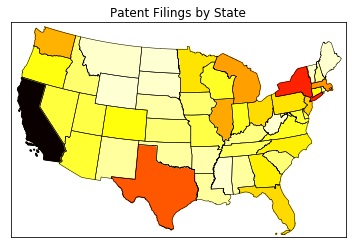

In [3]:
my_map = Basemap(projection='ortho', lat_0=50, lon_0=-100, resolution='l', area_thresh=1000.0)

# create and draw map with 2017 US census shapefiles (https://www.census.gov/geo/maps-data/data/tiger.html)
my_map = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
shape_info = my_map.readshapefile('./shapefiles/2017_us_state','states',drawbounds=True)

# choose a color for each state based on # of patents filed
colors = {}
state_abbrevs = []
cmap = plt.cm.hot
vmin = 0; vmax = state_counts_df.patents_filed.max() # setting minimum and maximum values
for shapedict in my_map.states_info:
    state_abbreviation = shapedict['STUSPS']
    if state_abbreviation in state_counts_df.index:
        patents = state_counts_df.loc[state_abbreviation,'patents_filed']
        colors[state_abbreviation] = cmap(1.-np.sqrt(patents/vmax))[:3]
    else:
        patents = 0
        colors[state_abbreviation] = cmap(1.)[:3]
    state_abbrevs.append(state_abbreviation)

# loop over states and color each state
ax = plt.gca() # get current axes instance
for nshape,seg in enumerate(my_map.states):
    if state_abbrevs[nshape] not in ['AK','HI']: # skipping states that are not part of lower 48 for plotting
        color = rgb2hex(colors[state_abbrevs[nshape]]) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)

plt.title("Patent Filings by State")

plt.show()

#### Observations

Based on the color map above, it is clear that filing activity for patents issuing in 2017 is relatively high in states like California, New York and Texas (as measured by applicant location).  As would be expected, more rural states have less applicants.  

<b>Note:</b> for the purposes of this visualization, only the lower 48 states have been plotted.  Alaska and Hawaii have relatively little filing activity when compared to the rest of the country.

## Time Series Exploration

#### Creation of datetime indexed DataFrame

In [4]:
# create DataFrame with a sorted datetime index 
filing_ts_df = pd.DataFrame(all_patents_df.filing_date.value_counts()).sort_index()

# change column name to 'filings'
filing_ts_df = filing_ts_df.rename(columns={'filing_date':'filings'})

# add running total column and calculate cumulative sum of filings
filing_ts_df['running_total'] = filing_ts_df.filings.cumsum()

filing_ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4203 entries, 1986-01-22 to 2017-10-09
Data columns (total 2 columns):
filings          4203 non-null int64
running_total    4203 non-null int64
dtypes: int64(2)
memory usage: 98.5 KB


#### Visualizing time series data

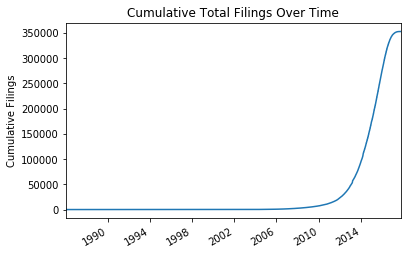

In [5]:
filing_ts_df.running_total.plot()
plt.title("Cumulative Total Filings Over Time")
plt.ylabel("Cumulative Filings")

plt.show()

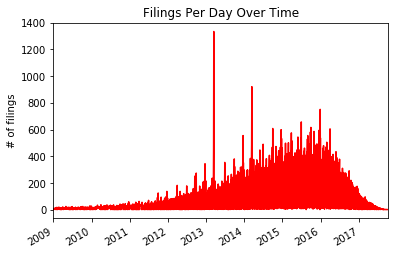

In [6]:
filing_ts_df.filings['2009':].plot(color='red')
plt.title("Filings Per Day Over Time")
plt.ylabel("# of filings")

plt.show()

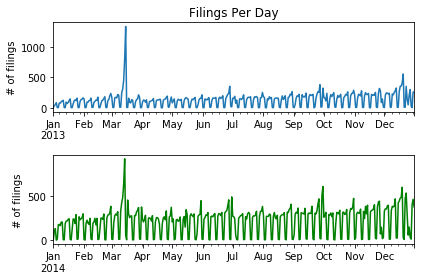

In [7]:
plt.subplot(2,1,1)
filing_ts_df["2013"].filings.plot()
plt.title("Filings Per Day")
plt.ylabel("# of filings")

plt.subplot(2,1,2)
filing_ts_df["2014"].filings.plot(color='green')
plt.ylabel("# of filings")

plt.tight_layout()

plt.show()

#### Time Series Observations

The distribution of filing dates over time is heavily left skewed due to a very small number of extremely old filing dates.  For that reason, the subsequent plots focus only on patents with a filing date in 2010 or later.

The number of filings per day is distributed normally around the expected filing date given all patents in the sample were granted in 2017 (i.e., see below for median prosecution period of 950 days for utility patents).

Interestingly, there is a significant spike observed in 2013 and 2014 at the same time (i.e., mid-March). Furthermore, the subplots focusing on 2013 and 2014 show a similar distribution trend of filing activity with several smaller yet noticeable spikes in activity: late June, late September/early October and late December.  

Additional research is necessary to determine the cause of these daily filing activity patterns from year to year.

## Metadata Trends

#### Number of Claims

In [8]:
# show summary statistics for number of claims
all_patents_df.number_of_claims.describe()

count    352567.000000
mean         14.817195
std           9.122482
min           1.000000
25%           9.000000
50%          16.000000
75%          20.000000
max         381.000000
Name: number_of_claims, dtype: float64

###### Selecting Utility Patents

For the purpose of the deep dive analysis, this project will focus on utility patent types and exclude plant patents, design patents, and reissue patents.  From a domain experience perspective, utility patents have more variation in the number of claims and subject matter covered.  Plant patents and design patents are very different from utility patents but the legal distinction is beyond the scope of this project.  

In [9]:
utility_patents_df = all_patents_df[all_patents_df.application_type == 'utility']

utility_patents_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319983 entries, 649 to 352566
Data columns (total 13 columns):
application_number          319983 non-null int64
application_type            319983 non-null object
city                        319983 non-null object
country                     319983 non-null object
filing_date                 319983 non-null datetime64[ns]
grant_date                  319983 non-null datetime64[ns]
invention_title             319983 non-null object
number-of-drawing-sheets    319983 non-null int64
number-of-figures           319983 non-null int64
number_of_claims            319983 non-null int64
patent_number               319983 non-null object
state                       319983 non-null object
US_State                    319983 non-null bool
dtypes: bool(1), datetime64[ns](2), int64(4), object(6)
memory usage: 32.0+ MB


In [10]:
# show summary statistics for number of claims in utility patent
utility_patents_df.number_of_claims.describe()

count    319983.000000
mean         16.199423
std           8.377739
min           1.000000
25%          11.000000
50%          17.000000
75%          20.000000
max         381.000000
Name: number_of_claims, dtype: float64

###### Handling Outliers

From the summary statistics on number of claims across the entire set, we see that the median number of claims is 17, while the maximum is 381.  This indicates that the distribution will be skewed to the right.  When reviewing the data, this observation can be seen by looking at the `.value_counts()` for each distinct value in the `number_of_claims` column. From industry experience, one would understand that most utility patent applications have less than 50 claims.  So, in order to create a better distribution, we will narrow down this data set by removing those patents with a number of claims that is greater than 3 standard deviations from the median value.

In [11]:
claims_std_dev = utility_patents_df.number_of_claims.std()
claims_median = utility_patents_df.number_of_claims.median()

utility_patents_subset_df = utility_patents_df[utility_patents_df.number_of_claims <= (claims_median + 3*claims_std_dev)].copy()

###### Visualizing Number of Claims Distribution

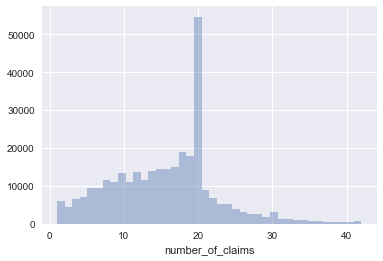

In [12]:
sns.set(color_codes=True)

# plot basic histogram 
sns.distplot(utility_patents_subset_df.number_of_claims, bins=40, kde=False)

plt.show()

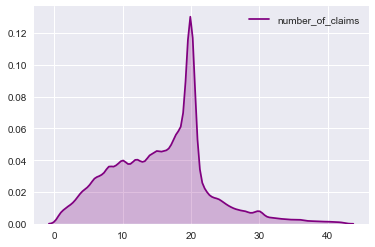

In [13]:
# plot KDE 
sns.kdeplot(utility_patents_subset_df.number_of_claims, shade=True, color="purple")

plt.show()

###### Observations re: Number of Claims Distribution

The number of claims in the utility patents subset is not normally distributed and converges around 20 claims.  This is consistent with <a href="https://www.uspto.gov/learning-and-resources/fees-and-payment/uspto-fee-schedule">fee schedule at the USPTO</a> which requires applicants to pay extra for each claim in excess of 20.

#### Prosecution Period

The time period during which a patent application is being "prosecuted" begins with the filing date and ends with the grant date.  This analysis uses a measure of the prosecution period in days between filing and grant.

In [14]:
# create new column 'prosecution_period' as difference between grant date and filing date
utility_patents_subset_df['prosecution_period'] = utility_patents_subset_df.grant_date - utility_patents_subset_df.filing_date

# convert timedelta to integer number of days
utility_patents_subset_df.prosecution_period = utility_patents_subset_df.prosecution_period.apply(lambda x: x.days)

# show summary statistics for prosecution period
utility_patents_subset_df.prosecution_period.describe()

count    316685.000000
mean       1063.678700
std         620.980377
min          60.000000
25%         627.000000
50%         950.000000
75%        1355.000000
max       11493.000000
Name: prosecution_period, dtype: float64

###### Visualizing Distribution

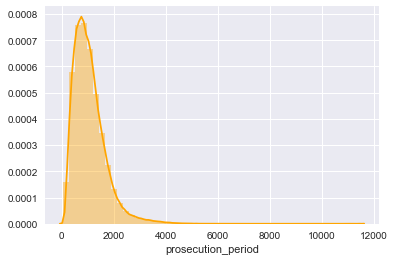

In [15]:
# plot histogram with KDE curve
sns.distplot(utility_patents_subset_df.prosecution_period, color="orange")

plt.show()

###### Handling Outliers

Based on the above histogram with KDE plot, we can see that the prosecution period is distributed normally around the median value and skewed by a long tail on the right side.  Similar to the narrowing of the data set that we performed for the `number_of_claims` column, we will filter out all of the values that are greater than 3 standard deviations from the median value.

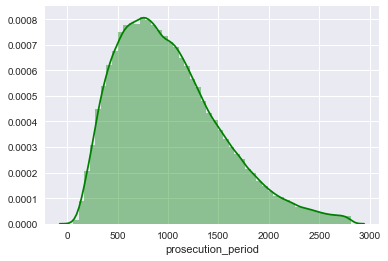

In [16]:
pros_std_dev = utility_patents_subset_df.prosecution_period.std()
pros_median = utility_patents_subset_df.prosecution_period.median()
utility_patents_subset_df = utility_patents_subset_df[utility_patents_subset_df.prosecution_period <= (pros_median + 3*pros_std_dev)]

# plot normalized distribution
sns.distplot(utility_patents_subset_df.prosecution_period, color="green")

plt.show()

#### Number of Figures

In [17]:
utility_patents_subset_df['number-of-figures'].describe()

count    310513.000000
mean         14.229285
std          25.996882
min           0.000000
25%           6.000000
50%          10.000000
75%          17.000000
max        7289.000000
Name: number-of-figures, dtype: float64

###### Visualizing Distribution

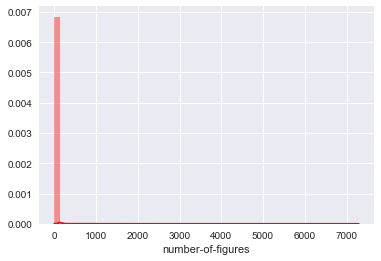

In [18]:
sns.distplot(utility_patents_subset_df['number-of-figures'], color="red")

plt.show()

###### Handling Outliers

We can see that the observed data is not normally distributed and, from the summary statistics above, heavily right-skewed by a staggering max of 7289 figures. Again, as we did above, we will focus only the values that are not greater than 3 standard deviations from the median value.

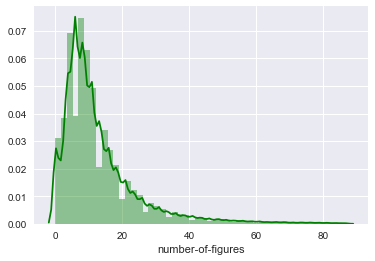

In [19]:
figs_std_dev = utility_patents_subset_df['number-of-figures'].std()
figs_median = utility_patents_subset_df['number-of-figures'].median()
utility_patents_subset_df = utility_patents_subset_df[utility_patents_subset_df['number-of-figures'] <= (figs_median + 3*figs_std_dev)]

# plot normalized distribution
sns.distplot(utility_patents_subset_df['number-of-figures'], color="green")

plt.show()

###### Observations re: Number of Figures Distribution

While still right-skewed by some grants having larger figure counts, when viewed within 3 standard deviations from the median, we see that the majority of the applications contain between 0 and 20 figures.

#### Figure Density

For the purposes of this analysis, the term <i>figure density</i> will refer to the average number of figures per drawing sheet for each granted patent.

In [20]:
# create new column 'figure_density' as difference between grant date and filing date
utility_patents_subset_df['figure_density'] = utility_patents_subset_df['number-of-figures'] / utility_patents_subset_df['number-of-drawing-sheets']

# show summary statistics for figure density
utility_patents_subset_df['figure_density'].describe()

count    295732.000000
mean          1.406862
std           0.579786
min           0.013575
25%           1.000000
50%           1.200000
75%           1.625000
max          22.000000
Name: figure_density, dtype: float64

###### Visualizing Distribution

<b>Note:</b> when deviding with zeros, NaN values are returned in the `figure_density` column.  In order to plot the distribution of densities, we need to drop the NaN values.  Therefore, `figure_density_df` (created below) will only reflect patent grants that contained at least 1 figure. 

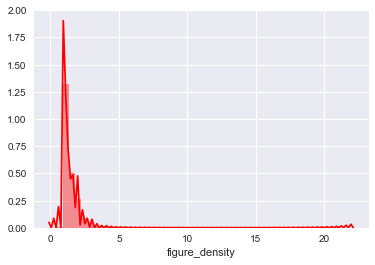

In [21]:
# drop NaN values for purposes of analysis 
figure_density_df = utility_patents_subset_df.dropna()

sns.distplot(figure_density_df.figure_density, color="red")

plt.show()

## Relationships Between Variables

#### Number of Claims vs. Prosecution Period

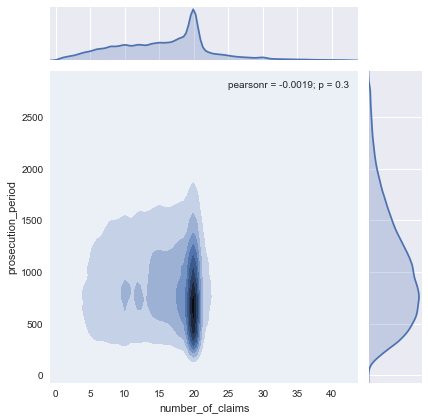

In [22]:
sns.jointplot(x='number_of_claims', y='prosecution_period', data=utility_patents_subset_df, kind="kde")
plt.show()

<b>Obeservation:</b> there is no correlation between number of claims and prosecution time, however, the above plot shows a convergance around 10, 15 and especially 20 claims.

#### Figure Density vs. Prosecution Period

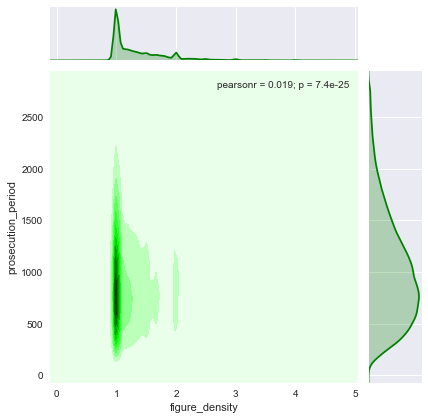

In [24]:
sns.jointplot(x='figure_density', y='prosecution_period', data=figure_density_df[figure_density_df.figure_density < 5], kind="kde", color="green")
plt.show()

<b>Observation:</b> there is no correlation between figure density and prosecution period, however, the above plot reveals a convergance around a figure density of '1' (i.e., 1 figure per drawing sheet) and '2' which supports common sense and intuition.  If one were to pick up a random patent, most drawing sheets would have 1 or 2 figures.

#### Number of Figures vs. Prosecution Period

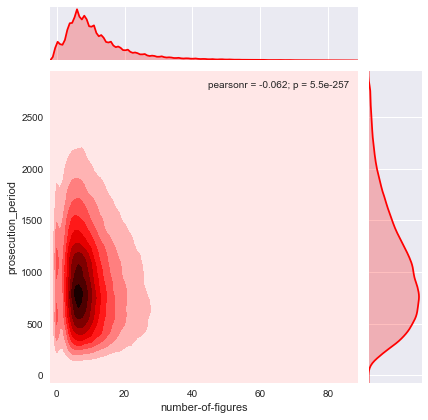

In [25]:
sns.jointplot(x='number-of-figures', y='prosecution_period', data=utility_patents_subset_df, kind="kde", color="red")
plt.show()

<b>Observation:</b> there is a very weak correlation between number of figures and prosecution time, however, the above plot reveals a convergence around ~10.  Interestingly, the more figures added to a patent, the closer the prosecution would be to the observed median prosecution time (<i>see above</i>, 950 days).